# Calculating Median Pressures of Raman CO2 calibration analyses from ESI-TEC software log 
- This workbook shows how to extract and calculate median+standard deviation of pressure log data from the ESI-TEC software files corresponding to calibration analyses.
- This data is from Devitre et al. (2021), collected from acqusitions on a high pressure optical cell on the Cornell WITec Alpha300R. 

In [1]:
# Import useful python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import os
import datetime

## Downloading DiadFit locally
- The easiest way to install diad fit is by removing the #. It will install from PyPI
- You only need to do this once on each computer, or run in order to grab an updated version. 

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!


In [2]:
import DiadFit as pf
pf.__version__

'0.0.58'

## Extracting information from the ESI-TEC report files (.docx)
- ESI-Tec software exports a report in word document format, in which the absolute start time of the analysis,serial number of the sensor and other information are stored that we need to access

### First, we identify the report files

In [3]:
path=r"C:\Users\charl\Documents\Instruments and calibrations\UCB_4-10-23"
filetype_reports=['.docx']

report_files=pf.Psensor.get_files(path=path,filetype=filetype_reports)
display(report_files)

['041023_37Cexperiment2.docx', 'Report_20230411_065351.docx']

### The, we strip the start time of the analysis and the serial number of the sensor from the file

In [4]:
j=0
rep=report_files[j]

start_time,sn_str=pf.Psensor.report_info(path=path,report=rep)

2023-04-10 11:09:18
Serial No. 0132212


## Extracting pressure data from the ESI-TEC pressure log
- ESI-TEC software exports the full pressure log to either excel or csv, which we extract here

### First, we identify the data files 
- These could be excel or csv, we can load either

In [5]:
filetype=['.csv','.xlsx']

pfiles=pf.Psensor.get_files(path=path,filetype=filetype)
display(pfiles)

['041023_37Cexperiment.csv',
 '041023_37Cexperiment_ESITEC_out.xlsx',
 'Experiment_37C_4-10-23.xlsx',
 'merged_dataframe.xlsx',
 'UCB_4-10-23_Calibration_fitting_w_sec_pg.xlsx',
 '~$Experiment_37C_4-10-23.xlsx',
 '~$merged_dataframe.xlsx']

### Now pick a file to start with and read in the data
- Here we will obtain a Date and Time column based on the report start time and a Timestamp column (UNIX time)

In [6]:
i=1 # select filenumber in pfiles
print(pfiles[i])

pdata=pf.Psensor.read_pfiles(path=path,file=pfiles[i],start_time=start_time,sn_name=sn_str)
display(pdata.head())

041023_37Cexperiment_ESITEC_out.xlsx


,Time_sincestart,Pressure / MPa,Temperature / °C,Date and Time,unix_timestamp
0,00:00:00.000000,0.100957,23.078125,2023-04-10 11:09:18.000000,1.681125e+09
1,00:00:02.999194,0.101022,23.080078,2023-04-10 11:09:20.999194,1.681125e+09
2,00:00:06.000153,0.101470,23.091797,2023-04-10 11:09:24.000153,1.681125e+09
3,00:00:08.999278,0.100740,23.080078,2023-04-10 11:09:26.999278,1.681125e+09
4,00:00:11.999985,0.100636,23.082031,2023-04-10 11:09:29.999985,1.681125e+09


### We can plot the pressure data with Date and Time 

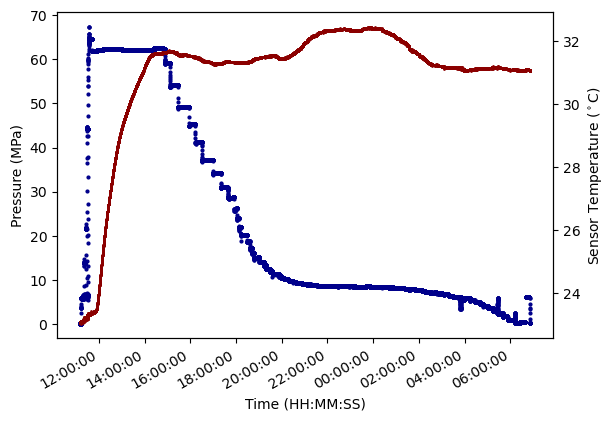

In [7]:
fig, ax = plt.subplots()

ax.plot_date(pdata['Date and Time'],pdata['Pressure / MPa'],'o',markersize=2,color='darkblue',zorder=0)
ax2=ax.twinx()
ax2.plot_date(pdata['Date and Time'],pdata['Temperature / °C'],'o',markersize=1,color='darkred',zorder=0)

ax.set_xlabel(r"Time (HH:MM:SS)")
ax.set_ylabel(r"Pressure (MPa)")
ax2.set_ylabel(r"Sensor Temperature ($^\circ$C)")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

## Now read in the calibration analysis data 
- This is output xlsx by "Stitch_Outputs_Together.pynb" using DiadFit. 
- You could also simply use a metadata table, but it must have the correct format as output by DiadFit metadata loop functions.

In [8]:
sdata_base = pd.read_excel(r"C:\Users\charl\Documents\Instruments and calibrations\OUTPUT\UCB_4-10-23_Calibration_fitting_w_sec_pg.xlsx")
sdata_base=sdata_base.drop(columns={'Unnamed: 0'}) # drop unnamed column
display(sdata_base.head())

,filename_x,Corrected_Splitting,Splitting,Diad1_Combofit_Cent,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,...,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,Ne_Correction
0,FDCA-P26-1,104.289545,104.545351,1282.504157,367.496362,1282.504157,1052.927596,1.024066,3.267903,0.746348,...,10,35.089,20,5,5,"['0h', '1m', '42s']",8:14:34 PM\n,72874,1325.004,0.997553
1,FDCA-P53-1,103.472820,103.724480,1284.258669,1326.523430,1284.258669,3218.620131,0.896086,10.574944,0.666599,...,11,34.653,20,5,5,"['0h', '1m', '42s']",1:23:33 AM\n,91413,1325.004,0.997574
2,FDCA-P54-1,103.455136,103.706735,1284.314711,1241.314871,1284.314711,2984.081547,0.892089,9.241941,0.654681,...,11,34.703,20,5,5,"['0h', '1m', '41s']",1:30:06 AM\n,91806,1325.004,0.997574
3,FDCA-P56-2,103.416665,103.668123,1284.424338,1071.698051,1284.424338,2500.257715,0.859701,7.989505,0.671815,...,11,34.668,20,5,5,"['0h', '1m', '41s']",1:50:00 AM\n,93000,1325.004,0.997574
4,FDCA-P57-2,103.374908,103.626243,1284.511355,1295.911503,1284.511355,2890.272428,0.827629,9.110221,0.654708,...,11,34.660,20,5,5,"['0h', '1m', '42s']",2:01:13 AM\n,93673,1325.004,0.997575


# Calculate the datetime, unix timestamp and duration of each analysis
- Here we can specify a time offset between the raman computer and the pressure recording computer
- For this dataset, the raman computer was about ~4 minutes ahead of the pressure recording computer. If we specify df=sdata,raman_cpu_offset='ahead',offset_hms=[0,5,0] as arguments of the function, we will immediately at the end that the standard deviations of the pressure medians are much lower. If instead we said raman_cpu_offset='none', we can see at the end that the standard deviations are large for some samples.

In [9]:
sdata=pf.Psensor.add_datetime_and_duration_cols(df=sdata_base,raman_cpu_offset='ahead',offset_hms=[0,5,44])
sdata.head()

,filename_x,Corrected_Splitting,Splitting,Diad1_Combofit_Cent,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,...,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,Ne_Correction,Date and Time,Date and Time - offset,unix_timestamp,duration_s
0,FDCA-P26-1,104.289545,104.545351,1282.504157,367.496362,1282.504157,1052.927596,1.024066,3.267903,0.746348,...,5,"['0h', '1m', '42s']",8:14:34 PM,72874,1325.004,0.997553,2023-04-10 20:14:34,2023-04-10 20:08:50,1.681157e+09,102.0
1,FDCA-P53-1,103.472820,103.724480,1284.258669,1326.523430,1284.258669,3218.620131,0.896086,10.574944,0.666599,...,5,"['0h', '1m', '42s']",1:23:33 AM,91413,1325.004,0.997574,2023-04-11 01:23:33,2023-04-11 01:17:49,1.681176e+09,102.0
2,FDCA-P54-1,103.455136,103.706735,1284.314711,1241.314871,1284.314711,2984.081547,0.892089,9.241941,0.654681,...,5,"['0h', '1m', '41s']",1:30:06 AM,91806,1325.004,0.997574,2023-04-11 01:30:06,2023-04-11 01:24:22,1.681176e+09,101.0
3,FDCA-P56-2,103.416665,103.668123,1284.424338,1071.698051,1284.424338,2500.257715,0.859701,7.989505,0.671815,...,5,"['0h', '1m', '41s']",1:50:00 AM,93000,1325.004,0.997574,2023-04-11 01:50:00,2023-04-11 01:44:16,1.681177e+09,101.0
4,FDCA-P57-2,103.374908,103.626243,1284.511355,1295.911503,1284.511355,2890.272428,0.827629,9.110221,0.654708,...,5,"['0h', '1m', '42s']",2:01:13 AM,93673,1325.004,0.997575,2023-04-11 02:01:13,2023-04-11 01:55:29,1.681178e+09,102.0


# Calculate the median pressure and median absolute deviation for each analysis
- This portion calculates the median pressures for each analysis based on the timestamps, and then merges the results back in with the analysis dataset
- Make sure that the time on each acquisition computer is the same or if you know the offset correct the time in one of the datasets

## Calculate median pressure and median absolute deviation for each analysis

In [10]:
# Calculate median pressure intra-analysis and 1 median absolute deviation
p_medians=pf.Psensor.get_p_medians(pdata=pdata,sdata=sdata)
display(p_medians.head())

,filename_x,start_time_P,end_time_P,median_pressure,mad_pressure,median_temp,mad_temp
0,FDCA-P26-1,2023-04-10 20:08:48.828809984,2023-04-10 20:10:30.828809984,10.127584,0.001346,31.470703,0.003772
1,FDCA-P53-1,2023-04-11 01:17:50.408428800,2023-04-11 01:19:32.408428800,8.104985,0.001739,31.968750,0.002191
2,FDCA-P54-1,2023-04-11 01:24:23.382980096,2023-04-11 01:26:04.382980096,8.019562,0.001345,31.935547,0.005042
3,FDCA-P56-2,2023-04-11 01:44:17.296997120,2023-04-11 01:45:58.296997120,7.868320,0.001207,31.692383,0.002413
4,FDCA-P57-2,2023-04-11 01:55:29.243060224,2023-04-11 01:57:11.243060224,7.727907,0.000595,31.597656,0.004990


## Merge results into analysis dataset and plot
- Here, check that the standard deviations are small, plot can help ID issues like mismatching computer time
- In this dataset, for instance, the CPU time on the computer where the Raman analyses were made and the pressure recording laptop was slightly different (by 4 minutes), in a case like this, you'll want to adjust the time of the analyses, you can go back and do this then recalculate the medians.

,filename_x,Corrected_Splitting,Splitting,Diad1_Combofit_Cent,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,...,Date and Time,Date and Time - offset,unix_timestamp,duration_s,start_time_P,end_time_P,median_pressure,mad_pressure,median_temp,mad_temp
97,FDCA-P1-1,105.278861,105.542330,1280.792491,4867.117554,1280.792541,13387.837947,0.953561,5.548645,0.841382,...,2023-04-10 14:42:42,2023-04-10 14:36:58,1.681137e+09,102.0,2023-04-10 14:36:59.349467904,2023-04-10 14:38:41.349467904,62.489000,0.000706,31.603516,0.002679
98,FDCA-P1-2,105.280266,105.543643,1280.792425,5098.573503,1280.792475,13979.555935,0.950302,6.264735,0.841968,...,2023-04-10 14:47:27,2023-04-10 14:41:43,1.681138e+09,102.0,2023-04-10 14:41:44.324145152,2023-04-10 14:43:26.324145152,62.473144,0.001202,31.611328,0.002685
99,FDCA-P1-3,105.290329,105.553558,1280.781620,4778.454204,1280.781670,13157.924063,0.947101,5.704327,0.860791,...,2023-04-10 14:56:05,2023-04-10 14:50:21,1.681138e+09,102.0,2023-04-10 14:50:20.291985920,2023-04-10 14:52:02.291985920,62.452215,0.001161,31.642578,0.003603
117,FDCA-P2-1,105.255676,105.518715,1280.825834,4542.302741,1280.825884,12450.272583,0.946703,5.250776,0.850917,...,2023-04-10 15:01:17,2023-04-10 14:55:33,1.681139e+09,102.0,2023-04-10 14:55:32.269398016,2023-04-10 14:57:14.269398016,59.265227,0.001133,31.650391,0.004547
118,FDCA-P2-2,105.255296,105.518233,1280.825999,4654.776146,1280.826049,12838.667721,0.962176,5.180837,0.830392,...,2023-04-10 15:06:24,2023-04-10 15:00:40,1.681139e+09,102.0,2023-04-10 15:00:41.247139840,2023-04-10 15:02:23.247139840,59.250048,0.001667,31.667969,0.003524


(19457.567337962962, 19458.294988425925)

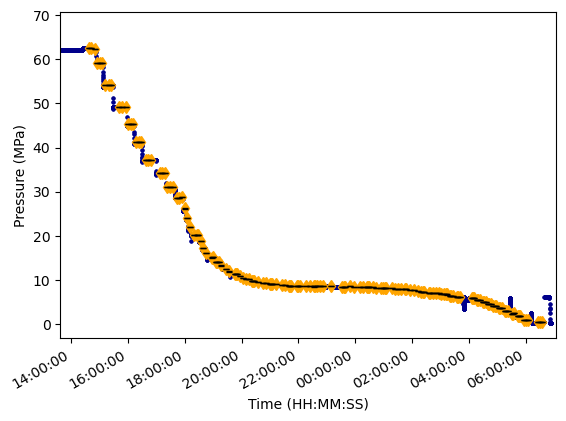

In [11]:
# Merge this into the OG spectal dataframe
merged_data=pd.merge(left=sdata,right=p_medians,how='outer',left_on='filename_x',right_on='filename_x')
# sort the dataframe by date and time
merged_data.sort_values(by='Date and Time',inplace=True)

display(merged_data.head())

show_temp=False # If you want to show the sensor temperature averages as well, change to True

fig, ax = plt.subplots()

ax.plot_date(pdata['Date and Time'],pdata['Pressure / MPa'],'o',markersize=2,color='darkblue',zorder=1)

ax.plot_date(pdata['Date and Time'],pdata['Pressure / MPa'],'o',markersize=2,color='darkblue',zorder=1)
ax.errorbar(merged_data['Date and Time - offset'],merged_data['median_pressure'], yerr=merged_data['mad_pressure'], fmt='d',color='orange',mfc='orange', ecolor='black', capsize=2,barsabove=True,zorder=2)

if show_temp==True:
    
    ax2=ax.twinx()

    ax2.plot_date(pdata['Date and Time'],pdata['Temperature / °C'],'o',markersize=1,color='darkred',zorder=-1)
    ax2.errorbar(merged_data['Date and Time - offset'],merged_data['median_temp'], yerr=merged_data['mad_temp'], fmt='s',color='orange',mfc='orange', ecolor='black', capsize=2,barsabove=True,zorder=0)
    ax2.set_ylabel(r"Sensor Temperature ($^\circ$C)")

ax.set_xlabel(r"Time (HH:MM:SS)")
ax.set_ylabel(r"Pressure (MPa)")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()
plt.xlim(min(merged_data['Date and Time - offset'])-datetime.timedelta(hours=1),max(merged_data['Date and Time - offset'])+datetime.timedelta(hours=0.5))


## Export merged data to excel or clipboard

In [17]:
merged_data['filename_nocrr'] = merged_data['filename_x'].str.split('_', n=1).str[0]
#Export the updated dataframe to excel
merged_data.to_excel(path+'/'+'merged_dataframe.xlsx')
#Export the updated dataframe to clipboard
merged_data.to_clipboard(excel=True)

## FERMI SPLIT vs P

In [21]:
#creates a column with a new column that splits the filename to sample name (FDCA-P1-1 becomes FDCA-P1)
df=merged_data.copy()
df['filename_split'] = df['filename_x'].str.split('-', n=2).str[:2].str.join('-')
df.head()

,filename_x,Corrected_Splitting,Splitting,Diad1_Combofit_Cent,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,Diad1_Prop_Lor,...,Date and Time - offset,unix_timestamp,duration_s,start_time_P,end_time_P,median_pressure,mad_pressure,median_temp,mad_temp,filename_split
97,FDCA-P1-1,105.278861,105.542330,1280.792491,4867.117554,1280.792541,13387.837947,0.953561,5.548645,0.841382,...,2023-04-10 14:36:58,1.681137e+09,102.0,2023-04-10 14:36:59.349467904,2023-04-10 14:38:41.349467904,62.489000,0.000706,31.603516,0.002679,FDCA-P1
98,FDCA-P1-2,105.280266,105.543643,1280.792425,5098.573503,1280.792475,13979.555935,0.950302,6.264735,0.841968,...,2023-04-10 14:41:43,1.681138e+09,102.0,2023-04-10 14:41:44.324145152,2023-04-10 14:43:26.324145152,62.473144,0.001202,31.611328,0.002685,FDCA-P1
99,FDCA-P1-3,105.290329,105.553558,1280.781620,4778.454204,1280.781670,13157.924063,0.947101,5.704327,0.860791,...,2023-04-10 14:50:21,1.681138e+09,102.0,2023-04-10 14:50:20.291985920,2023-04-10 14:52:02.291985920,62.452215,0.001161,31.642578,0.003603,FDCA-P1
117,FDCA-P2-1,105.255676,105.518715,1280.825834,4542.302741,1280.825884,12450.272583,0.946703,5.250776,0.850917,...,2023-04-10 14:55:33,1.681139e+09,102.0,2023-04-10 14:55:32.269398016,2023-04-10 14:57:14.269398016,59.265227,0.001133,31.650391,0.004547,FDCA-P2
118,FDCA-P2-2,105.255296,105.518233,1280.825999,4654.776146,1280.826049,12838.667721,0.962176,5.180837,0.830392,...,2023-04-10 15:00:40,1.681139e+09,102.0,2023-04-10 15:00:41.247139840,2023-04-10 15:02:23.247139840,59.250048,0.001667,31.667969,0.003524,FDCA-P2


<ErrorbarContainer object of 3 artists>

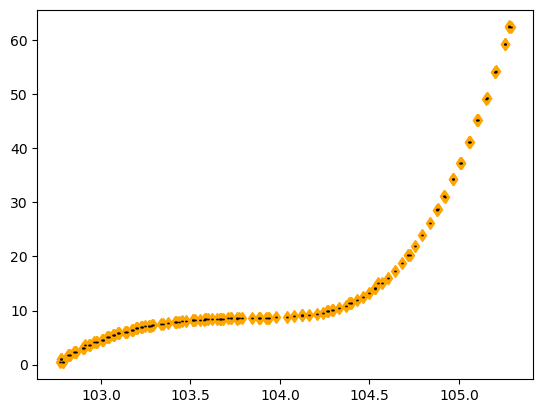

In [23]:
plt.errorbar(y=merged_data['median_pressure'],x=merged_data['Corrected_Splitting'], yerr=merged_data['mad_pressure'], fmt='d',color='orange',mfc='orange', ecolor='black', capsize=1,barsabove=True,zorder=2)
